In [91]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
import soundfile as sf
import json
import re 
import io

def mse(orig, quant):
    qerr = orig - quant
    sum_err = np.sum(qerr * qerr)
    return sum_err / orig.size

def mse_cplx(orig, quant):
    qerr_real = orig.real - quant.real
    qerr_imag = orig.imag - quant.imag
    sum_err = np.sum(qerr_real * qerr_real) + np.sum(qerr_imag * qerr_imag)
    return sum_err / (2*orig.size)

def qsnr(orig, quant):
    """Calculate the QSNR between two tensors
    """
    qerr = orig - quant
    sum_err = np.sum(qerr * qerr)
    sum_orig = np.sum(orig * orig)
    if sum_err > 0:
        if sum_orig < sum_err:
            if sum_orig == 0:
                return -math.inf
            else:
                # Means error is larger than signal
                return -int(round(10 * math.log10(sum_err/sum_orig), 0))
        # Error portion of signal
        return int(round(10 * math.log10(sum_orig/sum_err), 0))
    # Means no error
    return math.inf

In [92]:
file_path = "../samples/yes.wav"
data, samplerate = sf.read(file_path)

frame_size = 1024
n_fft = 1024
frame_step = 160

frame_idx = 46
frame = data[frame_idx*frame_step:frame_idx*frame_step+frame_size]
win_frame = np.pad(frame * np.hanning(frame_size), (0, n_fft - frame_size), "constant")
np_fft = np.fft.rfft(win_frame)

In [93]:

Shift = 0
out_preemph_c = np.array([
		-240, -2750, -1077, 3140, 2383, -2524, -3680, 538, 3737, 1565, -2664, -2712, 1168, 2268, -13, -680, -133, -790, -465, 1223, 995, -799, -1050, -127, 374, 440, 128, -347, -485, -369, -178, 545, 639, -726, -1328, -79, 868, 194, -573, -558, -417, -93, 390, 270, -408, -700, -352, 286, 592, -69, -772, -339, 305, 178, -83, -111, -237, -361, -156, 93, 5, -376, -568, -278, -90, -251, -474, -307, -471, -755, 850, 1551, -1549, -3288, 683, 4203, 896, -4026, -2708, 2508, 3802, -153, -3315, -1117, 2172, 1285, -513, -56, -191, -1006, 111, 1428, 373, -977, -542, 114, 191, 235, 148, -134, -359, -581, -134, 849, 399, -1086, -984, 371, 558, -225, -420, -265, -355, -118, 294, 164, -303, -476, -251, 197, 351, -159, -383, -29, 18, -151, 93, 237, -265, -594, -232, 134, -67, -372, -360, -266, -442, -519, -150, -18, -707, -1206, 773, 2213, -1103, -4099, -148, 4920, 1964, -4229, -3712, 2162, 4419, 625, -3385, -1884, 1940, 1647, -380, -20, 128, -1196, -469, 1501, 781, -958, -675, 76, 5, -57, 151, 179, -107, -812, -794, 533, 891, -523, -1275, -233, 415, -37, -159, -33, -429, -532, -11, 264, 196, -122, -566, -404, 339, 429, -65, -236, -267, -234, 152, 349, -85, -461, -358, -210, -140, -14, -129, -562, -792, -484, 120, 14, -884, -1123, -631, 909, 2067, -667, -4037, -1355, 4252, 3448, -2641, -4573, -2, 4079, 2581, -1934, -2987, 423, 1876, 379, 159, 301, -1092, -1087, 935, 1201, -313, -641, -220, -290, -203, 202, 322, 83, -617, -1151, -136, 1010, 228, -985, -729, -81, -111, 60, 356, -250, -880, -422, 376, 626, 45, -737, -501, 420, 474, -134, -183, 22, -85, -175, -50, 60, 71, -278, -754, -380, 301, 43, -699, -834, -252, 48, -368, -882, -633, -480, -210, 1605, 1295, -2972, -3930, 2215, 5846, 440, -5643, -3328, 3463, 5121, -48, -4173, -1419, 2300, 1318, -171, 449, -273, -1594, -202, 1441, 482, -657, -421, -223, -361, -254, 81, 505, 248, -1095, -1364, 265, 1121, 38, -876, -680, -409, -7, 667, 371, -674, -828, -80, 516, 497, -112, -526, -130, 257, 106, 28, 252, 91, -404, -477, 56, 530, 93, -806, -832, 18, 256, -373, -656, -358, -240, -412, -620, -368, -146, -562, -1186, -542, 2280, 2144, -3148, -4711, 1982, 6407, 1166, -5297, -3726, 2667, 5130, 1000, -3472, -1802, 1609, 1065, 169, 1161, 24, -2057, -638, 1360, 509, -383, -19, -437, -966, -459, 212, 749, 433, -1228, -1752, 84, 1139, 157, -415, -475, -957, -488, 910, 974, -377, -1102, -513, 505, 866, 154, -537, -229, 228, 80, 67, 353, 74, -537, -496, 175, 424, -173, -647, -369, -230, -533, -204, 210, -348, -1000, -739, 67, 186, -534, -1191, -734, -348, -430, 1668, 2636, -2356, -5691, 835, 7387, 2867, -5403, -5260, 1931, 5986, 2144, -3517, -2657, 1432, 1327, -71, 1179, 545, -2272, -1353, 1386, 789, -716, -301, -121, -718, -941, -694, 468, 1305, -379, -2270, -1018, 967, 905, 173, -505, -1297, -789, 900, 1298, 61, -879, -644, 263, 764, 325, -204, -134, 34, -86, -48, 154, 105, -76, -254, -437, -439, -30, 297, -226, -1063, -873, 207, 342, -667, -974, -252, 122, -406, -753, -442, -93, -349, -826, -1092, -468, 2553, 3395, -2694, -6695, 517, 8364, 4117, -5372, -6340, 1233, 6434, 3022, -3159, -2885, 878, 741, -128, 1723, 870, -2628, -1823, 1156, 480, -908, -24, 172, -865, -1333, -999, 403, 1582, 198, -1797, -1204, 253, 458, 743, 826, -712, -1689, -67, 1709, 1152, -461, -941, -143, 664, 552, -124, -233, 319, 227, -489, -497, 198, 408, -196, -390, -164, -503, -729, 11, 430, -284, -980, -918, -149, 543, 110, -812, -627, -56, -282, -381, 262, -6, -1221, -1777, -708, 3607, 5425, -2739, -9512, -679, 10787, 6452, -6033, -8403, 419, 7380, 4190, -3207, -3435, 955, 512, -943, 1894, 1805, -2600, -2374, 1015, 162, -1428, 245, 1221, -242, -2038, -2287, 362, 3023, 1127, -2316, -1842, 385, 880, 972, 995, -278, -1384, -341, 1315, 1295, 27, -597, 5, 465, 23, -432, 220, 899, 169, -832, -668, 14, 13, 6, 383, -149, -1505, -1203, 779, 1123, -522, -1405, -621, 315, 261, -272, -229, 43, -380, -731, 23, 658, -121, -979, -784, -372, -1112, 221, 5119, 3277, -7084, -7801, 5284, 11210, 1267, -8829, -5834, 4134, 7231, 503, -4231, -773, 947, -1836, -141, 3303, 36, -3489, -836, 1008, -969, -1048, 863, 1092, -429, -2403, -2349, 1096, 3357, 885, -2165, -1915, -63, 1353, 1773, 659, -1037, -1148, 487, 1286, 390, -248, 55, 208, 23, -323, -687, -153, 930, 733, -943, -1854, -654, 1008, 953, -550, -1388, -702, 152, -24, -375, 114, 404, -669, -1359, -169, 847, 251, -549, -472, -327, -403, -232, 47, -169, -911, -1717, -835, 3659, 5150, -2972, -8922, -386, 9811, 5848, -5055, -7665, -322, 6304, 3814, -2715, -2915, 428, -235, -860, 1574, 789, -2484, -1340, 1286, -385, -2378, -498, 1798, 1155, -1501, -3044, -927, 2509, 2345, -585, -1709, -763, 242, 1184, 1448, 120, -1077, -274, 1076, 633, -715, -384, 888, 759, -512, -1259, -778, 458, 1112, 205, -1324, -1602, -425, 719, 710, -361, -1042, -493, 129, -244, -407, 487, 624, -600, -1033, -86, 339, 35, 135, 127, -556, -940, -559, 88, 329, -406, -1629, -1923, 1313, 5493, 1630, -7193, -5380, 5684, 8485, -3, -6842, -3918, 3541, 5159, -392, -3094, -153, 463, -1166, 148, 1037, -1088, -1336, 740, 271, -2068, -1676, 1169, 2011, -342, -2323, -1441, 875, 1859, 622, -789, -473, 136, -88, 405, 1192, 172, -755, 396, 863, -429, -784, 262, 932, 740, -565, -1927, -872, 1378, 1191, -771, -1220, -570, -431, -116, 550, 442, -420, -930, -684, 207, 871, 199, -660, -158, 268, -577, -714, 436, 616, -409, -841, -477, -246, -134, -142, -591, -971, -1569, -460, 4333, 4667, -4476, -8332, 1732, 9352, 3702, -5131, -5909, 817, 5401, 1581, -2946, -790, 931, -1331, -830, 1310, -340, -1984, 29, 1259, -810, -2550, -1094, 1682, 1920, -714, -2356, -928, 1136, 1578, 588, -522, -611, 35, 654, 819, -36, -807, 352, 1523, 159, -1606, -1104, 693, 1541, 262, -1774, -1662, 239, 799, 10, -218, -379, -1074, -849, 542, 1032, -61, -963, -455, 491, 280, -574, -275, 643, 227, -885, -688, 121, 103, -277, -423, -355, -401, -730, -521, 26, -510, -1775, -1734, 1883, 5786, 1219, -7524, -4923, 5671, 7639, 412, -5250, -3640, 2324, 3854, -534, -1785, 622, -333, -1611, 393, 219, -2076, ])
out_window_c = np.array([
		0, 0, 0, 0, 0, -1, -1, 0, 2, 1, -2, -3, 2, 4, 0, -1, 0, -2, -1, 4, 4, -3, -5, -1, 2, 3, 1, -2, -4, -3, -2, 5, 6, -7, -14, -1, 11, 2, -8, -8, -6, -1, 6, 5, -7, -13, -7, 6, 13, -2, -18, -8, 8, 5, -2, -3, -7, -11, -5, 3, 0, -13, -20, -10, -3, -10, -19, -13, -20, -33, 39, 73, -75, -162, 35, 219, 48, -221, -152, 145, 225, -9, -206, -71, 141, 86, -35, -4, -14, -73, 8, 109, 29, -78, -44, 9, 16, 20, 13, -12, -33, -54, -13, 82, 39, -109, -101, 39, 59, -24, -46, -30, -40, -14, 35, 20, -37, -59, -32, 25, 46, -21, -51, -4, 2, -21, 13, 34, -39, -88, -35, 21, -10, -59, -58, -43, -73, -87, -25, -3, -123, -212, 138, 400, -202, -760, -28, 936, 378, -825, -733, 432, 895, 128, -702, -396, 412, 354, -83, -4, 28, -269, -107, 346, 182, -226, -161, 18, 1, -14, 38, 45, -27, -208, -206, 140, 236, -140, -345, -64, 114, -10, -45, -9, -123, -154, -3, 78, 58, -37, -172, -124, 105, 134, -20, -75, -86, -76, 50, 115, -28, -154, -121, -72, -48, -5, -45, -198, -282, -173, 43, 5, -325, -416, -235, 342, 784, -255, -1555, -526, 1663, 1359, -1049, -1830, -1, 1657, 1056, -797, -1240, 177, 790, 161, 68, 130, -473, -474, 411, 531, -139, -288, -99, -132, -93, 93, 149, 39, -290, -545, -65, 484, 110, -478, -356, -40, -55, 30, 178, -126, -446, -215, 193, 323, 23, -385, -263, 222, 252, -72, -98, 12, -46, -96, -27, 33, 39, -155, -424, -215, 171, 25, -401, -481, -146, 28, -216, -520, -375, -286, -126, 965, 783, -1805, -2399, 1359, 3603, 273, -3512, -2081, 2176, 3233, -30, -2659, -908, 1479, 851, -111, 293, -179, -1048, -133, 956, 321, -440, -283, -151, -245, -173, 55, 347, 171, -758, -948, 185, 785, 27, -619, -482, -291, -5, 479, 267, -487, -601, -58, 377, 365, -82, -389, -96, 191, 79, 21, 190, 69, -306, -363, 43, 406, 71, -621, -644, 14, 199, -291, -514, -281, -189, -326, -492, -293, -117, -450, -953, -437, 1843, 1739, -2560, -3842, 1621, 5256, 959, -4370, -3083, 2213, 4268, 834, -2905, -1512, 1353, 898, 143, 984, 20, -1753, -545, 1165, 437, -330, -16, -378, -838, -399, 185, 654, 379, -1077, -1541, 74, 1006, 139, -368, -422, -853, -436, 814, 873, -339, -992, -463, 457, 785, 140, -488, -209, 208, 73, 61, 324, 68, -495, -458, 162, 393, -161, -601, -344, -215, -498, -191, 197, -327, -940, -696, 63, 176, -505, -1128, -696, -331, -409, 1589, 2514, -2250, -5443, 800, 7083, 2752, -5194, -5062, 1861, 5775, 2071, -3401, -2572, 1388, 1287, -69, 1146, 530, -2213, -1319, 1353, 771, -700, -295, -119, -704, -924, -682, 460, 1284, -373, -2237, -1004, 954, 894, 171, -499, -1283, -781, 892, 1287, 60, -872, -639, 261, 759, 323, -203, -133, 34, -86, -48, 154, 105, -76, -253, -436, -438, -30, 297, -226, -1062, -872, 207, 342, -667, -974, -252, 122, -406, -753, -442, -93, -349, -826, -1092, -468, 2552, 3393, -2692, -6689, 516, 8354, 4111, -5363, -6327, 1230, 6417, 3013, -3149, -2875, 875, 738, -127, 1714, 865, -2612, -1811, 1148, 476, -901, -24, 170, -856, -1319, -988, 398, 1562, 195, -1772, -1186, 249, 451, 730, 811, -699, -1656, -66, 1673, 1127, -450, -919, -139, 647, 537, -121, -226, 309, 220, -473, -481, 191, 394, -189, -375, -158, -483, -699, 11, 411, -271, -935, -874, -142, 516, 104, -769, -593, -53, -266, -359, 246, -6, -1144, -1663, -661, 3364, 5051, -2546, -8826, -629, 9975, 5956, -5559, -7729, 385, 6763, 3833, -2928, -3130, 869, 465, -854, 1712, 1629, -2341, -2133, 910, 145, -1275, 218, 1086, -215, -1804, -2020, 319, 2658, 989, -2027, -1609, 335, 765, 843, 861, -240, -1191, -293, 1126, 1106, 23, -507, 4, 393, 19, -363, 185, 752, 141, -692, -554, 12, 11, 5, 314, -122, -1228, -978, 632, 908, -421, -1129, -498, 252, 208, -216, -181, 34, -299, -573, 18, 512, -94, -757, -604, -286, -852, 169, 3893, 2484, -5350, -5871, 3963, 8377, 943, -6551, -4313, 3045, 5307, 368, -3082, -561, 685, -1322, -101, 2361, 26, -2474, -590, 709, -679, -731, 600, 756, -296, -1650, -1606, 746, 2276, 597, -1455, -1282, -42, 898, 1171, 433, -679, -748, 316, 831, 251, -159, 35, 132, 15, -203, -430, -95, 576, 452, -578, -1132, -397, 609, 573, -329, -826, -416, 90, -14, -219, 66, 233, -384, -776, -96, 479, 141, -307, -262, -181, -222, -127, 26, -91, -490, -918, -444, 1933, 2705, -1552, -4632, -199, 5033, 2982, -2562, -3862, -161, 3137, 1886, -1335, -1424, 208, -113, -412, 750, 373, -1168, -626, 597, -177, -1089, -226, 812, 518, -669, -1347, -407, 1095, 1016, -252, -730, -324, 102, 495, 601, 49, -441, -111, 434, 253, -284, -151, 347, 295, -197, -481, -295, 172, 415, 76, -486, -584, -154, 258, 252, -127, -364, -171, 44, -83, -138, 163, 207, -198, -337, -28, 109, 11, 43, 40, -172, -288, -170, 26, 98, -120, -476, -557, 376, 1560, 458, -2003, -1483, 1551, 2293, -1, -1811, -1027, 918, 1324, -100, -778, -38, 114, -284, 36, 247, -256, -311, 170, 62, -466, -373, 257, 437, -74, -494, -303, 182, 381, 126, -158, -93, 27, -17, 77, 224, 32, -138, 72, 154, -76, -136, 45, 158, 123, -93, -313, -139, 217, 185, -118, -184, -85, -63, -17, 78, 62, -58, -126, -92, 27, 113, 25, -83, -20, 33, -69, -84, 50, 70, -46, -92, -51, -26, -14, -15, -59, -96, -152, -44, 404, 426, -401, -732, 149, 789, 306, -416, -469, 63, 411, 118, -215, -56, 65, -91, -55, 85, -22, -123, 2, 74, -47, -143, -60, 90, 100, -36, -116, -45, 53, 72, 26, -22, -25, 1, 26, 31, -1, -29, 12, 51, 5, -50, -33, 20, 44, 7, -47, -42, 6, 19, 0, -5, -8, -21, -16, 10, 18, -1, -15, -7, 7, 4, -7, -3, 7, 2, -9, -7, 1, 1, -2, -3, -2, -3, -4, -3, 0, -2, -7, -7, 6, 18, 3, -18, -10, 10, 12, 1, -6, -3, 2, 2, 0, -1, 0, 0, 0, 0, 0, 0, ])

out_swapped_fft = np.array([
	-376-373j, 133+189j, 16-40j, -7+33j, -33-55j, 11+6j, -14-8j, -13-11j, -6-6j, -10-10j, -7-8j, -29+3j, 4-91j, -7+156j, 49-110j, -70-14j, 2+10j, -7-5j, -7-9j, -3+0j, -4-16j, -13-1j, 3-11j, 8-16j, 39+33j, -177+114j, 49-428j, 78+517j, 40-344j, -113+68j, 19-2j, 2+3j, -8-4j, -7-9j, 4-7j, 2+1j, 22+14j, -45+73j, -124-130j, 183-16j, -85+29j, -3+31j, 25-17j, -3-19j, -21-1j, 1-5j, -6+3j, -2+5j, -14-5j, -15-7j, -14-31j, 61+7j, -56+30j, 6-30j, -3-5j, -12+8j, -1-14j, 3+2j, -8-6j, -3-6j, -6-3j, -4-10j, 10-11j, -5+20j, -36-14j, 36-5j, -28-3j, 13+10j, -11-16j, -3+3j, -2-4j, -4+4j, 4-6j, -1+1j, 2+5j, -16+11j, -12-34j, 30+10j, -38+4j, 28-3j, -26-18j, 6+9j, 0-8j, -9-9j, 6+14j, -8-4j, -4-5j, -6-1j, 14-19j, 1+24j, -26-14j, 25-1j, -17-2j, 8+5j, -3-20j, -15+21j, 11-11j, -10-7j, -1-3j, -2-5j, 15+1j, -20+26j, -18-33j, 31+4j, -30+11j, 18-12j, -8-16j, -9+29j, 3-26j, -5+9j, 5-1j, 4-7j, -14+8j, -12-2j, -1-32j, 16+30j, -23-17j, 14-4j, -14-3j, 17+25j, -11-49j, -4+33j, 3-12j, -15+1j, -12+5j, 6-37j, 25-1j, -4+39j, -46-41j, 47+7j, -15+8j, -9+7j, -7-24j, 26+36j, -21-47j, -17+12j, 16-4j, 30-18j, -2+40j, -48+13j, 5-59j, 41+43j, -54-18j, 22+1j, -9-20j, 14+36j, -21-63j, 38+37j, 28-1j, -3+34j, -94+78j, -44-136j, 164-94j, -54+251j, -138-169j, 178+49j, -104-52j, 93+112j, -182-167j, 235+106j, -92-78j, -14+95j, 143+100j, -405-78j, 132-248j, 492+250j, -627+26j, 317-340j, -106+508j, 51-389j, -40+250j, 146-254j, -194+312j, 219-135j, -331-102j, 89+164j, 81-448j, 176+444j, -244+141j, 185-643j, -82+630j, -273-231j, 382+12j, -37-7j, -161+88j, 116-125j, -348+16j, 518-85j, -275-128j, 203+335j, -344+16j, 57-414j, 644+662j, -936-555j, 426+103j, 29+128j, -67+200j, -188-468j, 359+309j, -129-601j, 174+780j, 138-424j, -704+363j, 174-367j, 608+70j, -767+523j, 475-947j, -82+505j, 26+142j, -366-97j, 457-263j, -173+257j, 252-210j, -333+235j, 122+41j, -143-316j, 142+185j, -62+122j, 0-287j, 59+282j, -14-191j, -22+41j, -14-33j, 40+138j, 7-65j, -81+7j, 41-49j, -18-77j, 87+170j, -141-85j, 199+2j, -209+91j, 31-303j, 133+315j, -85+39j, -4-269j, -67+144j, 8-160j, 273+247j, -313-294j, 162+538j, -173-491j, 245+140j, -376+326j, 433-801j, 105+681j, -586-161j, -278-206j, 1120+210j, -635-306j, 412+275j, -801+195j, 979-126j, -1450-267j, 1542+430j, -768+122j, -456-983j, 1917+843j, -1826-24j, 195-771j, 531-89j, -421+1556j, 1158-1330j, -1143+1073j, -346-1020j, 568+834j, 99-1158j, -517+1317j, 152-927j, 1235-196j, -1419+1736j, 286-2006j, 458+330j, -35+769j, -743-525j, 423+1060j, -168-1364j, 523+433j, -919-303j, 1178+962j, -1071-1271j, 865+822j, -427+698j, -374-1899j, 1066+1498j, -145-120j, -1085-444j, 632-125j, -902-34j, 1449+543j, -682-347j, 700-147j, -1608+388j, 1927-209j, -1402+354j, -39-834j, 1747+995j, -1859-301j, 277-63j, 853-609j, -763+215j, 927-291j, -1636+1243j, 1704-515j, -976+131j, 743-1099j, -1544+2039j, 1199-2331j, 846+940j, -1898+1784j, 593-2603j, 344+322j, 523+1054j, -73-904j, -286+1328j, -813-1638j, 484+1777j, 56-1292j, 624+867j, -1509-1344j, 1630+1000j, -654+505j, -812-1403j, 1219+844j, 107-242j, -743+213j, 438+330j, -514-848j, 656+434j, -1033-553j, 718+1125j, -482-675j, 1642+20j, -2138+192j, 520-476j, 1582+319j, -1724+172j, 598+465j, 16-1122j, -717+687j, 1244-480j, -1154+396j, 1036-329j, -1334+417j, 1726-355j, -1203+1038j, 72-2126j, 861+1657j, -827+390j, -214-1357j, 383+556j, 271-51j, -315-225j, 356+581j, -427-465j, 262+345j, -195-427j, 262+592j, -610-381j, 813-250j, -260+577j, -420-168j, 234-228j, 65-37j, 45+108j, 75+47j, -133-11j, 58+41j, -50-64j, 40+96j, -95-138j, 162+76j, -189+85j, 46-150j, 108+11j, -43+39j, 7+51j, -16-21j, -43-12j, 49+13j, -34-39j, 20+45j, -13-65j, 52+99j, -110-67j, 101-55j, -7+86j, -39+17j, 11-16j, -18-46j, -3+29j, 35-12j, -32-6j, 30+24j, -22-36j, 26+37j, -49-35j, 61+7j, -32+38j, -12-45j, 11-4j, -10+10j, 19+5j, 0-3j, -14-3j, 11+24j, -10-30j, 2+26j, 2-40j, 18+51j, -56-21j, 40-41j, 18+42j, -5-2j, -4-3j, -11-2j, -6+8j, 22-3j, -23-20j, 15+28j, 0-30j, 4+40j, -23-42j, 45+14j, -24+18j, -7-5j, -2-4j, 2-6j, 18+8j, -13-13j, -7+4j, 7+20j, 3-38j, -10+44j, 6-55j, 21+59j, -52-18j, 21-27j, 10+10j, 1+1j, -5+6j, 0+3j, 6+0j, 4-11j, -23+2j, 19+21j, -2-28j, -1+46j, -32-46j, 42+7j, -4+21j, -7-4j, -1+0j, -2-4j, -1-5j, -1+5j, 0+6j, 2-8j, 8-3j, -38+11j, 44-54j, 23+65j, -43-5j, 0-11j, 2-10j, 2-1j, 9+1j, -1+3j, 8-20j, -33+3j, -4+27j, 35+12j, 48-105j, -20+234j, -154-141j, 101-60j, 14+31j, 4+9j, 2+13j, -10-10j, 7+1j, 7+9j, 13+21j, 88-119j, -399+50j, 617+97j, -491+66j, 133-197j, 45+55j, -13+11j, -5+11j, 6-3j, -5+0j, 4+4j, -3-5j, 3+0j, 16+8j, -7-67j, -111+64j, 178+6j, -91+13j, 13-21j, 4+1j, 0+2j, 2-2j, -1-2j, 2-5j, 19+21j, -47-24j, 44+3j, -32+26j, 208+146j, ])

out_rfft = np.array([
	-375-2j, 169+27j, -8-29j, 18+18j, -40-12j, 14-3j, -6+3j, -7+0j, -3+1j, -5-1j, -2-1j, -8+16j, -43-49j, 86+79j, -31-83j, -39+29j, 9+2j, -2+0j, -6+0j, 1-1j, -8-5j, -3+4j, -2-8j, -4-13j, 42-9j, -20+156j, -222-243j, 346+211j, -181-195j, -10+97j, 12-9j, 5-2j, -1+0j, -10-1j, 2-7j, 3-3j, 20-10j, 25+67j, -138+9j, 81-126j, -21+69j, 20+9j, 5-20j, -15-13j, -7+12j, -1-3j, 1+2j, 1+1j, -5+5j, -7+5j, -26-12j, 35-31j, -1+46j, -16-21j, -1+1j, -3+6j, -3-5j, 1-3j, -5+0j, -4-1j, -2-1j, -7-2j, 2-13j, 19+10j, -31+14j, 14-27j, -13+14j, 15-6j, -13-7j, -2+4j, 0+1j, 1+0j, -3-6j, 0-1j, 7-2j, 1+18j, -33-8j, 26-24j, -14+29j, 9-26j, -16+17j, 10-7j, -4-5j, -11+2j, 12+0j, -3+2j, -4+0j, -6+0j, -9-19j, 25+6j, -25+14j, 12-22j, -10+14j, 13-11j, -19+1j, 10+10j, -2-10j, -9-2j, -4-1j, -4-2j, 16-18j, 11+29j, -36-4j, 20-24j, -8+22j, 5-16j, -15+8j, 14-4j, -12-6j, 0+2j, 8-1j, -4-9j, 3+7j, -15+17j, -13-26j, 33+6j, -33+7j, 18-15j, -18+12j, 22-7j, -25-7j, 17+13j, 2-16j, -18+17j, 0+10j, -21-20j, 14-44j, 39+44j, -70+13j, 43-42j, -17+28j, 16-15j, -27+9j, 30-2j, -30-3j, -11+9j, 10-25j, -15-33j, 54+15j, -7+80j, -79-74j, 92-13j, -72+52j, 34-41j, -37+20j, 39-11j, -73-17j, 48-14j, 37-47j, 28+27j, 77+155j, -237+12j, -38-329j, 363+251j, -363+94j, 220-255j, -163+177j, 188-130j, -294+169j, 268-245j, -191+67j, 129+65j, 270-219j, -309+645j, -358-319j, 668-708j, -267+1076j, -456-692j, 817+416j, -617-385j, 471+295j, -516-357j, 553+411j, -263-441j, -152+564j, 357-155j, -843-308j, 838+25j, 200+315j, -1058-374j, 848+200j, -337+289j, 475-499j, -554+154j, 363-119j, -346+333j, 236-77j, -332-234j, 7+150j, 705-297j, -533+625j, -306-321j, 954-376j, -925+581j, 397-399j, -80+628j, 409-808j, -585+728j, 8-696j, -167+433j, 410-472j, 159-147j, 96+1375j, -809-1040j, 498-440j, 435+1294j, -667-1160j, 317+603j, -459-137j, 786+397j, -731-759j, 450+219j, -373-177j, 391+377j, 134+40j, -955+38j, 932-392j, -64+413j, -689-259j, 955+208j, -785-282j, 339+110j, -358+136j, 751-199j, -453-29j, 306+95j, -561+167j, -82+52j, 599-702j, -269+932j, -185-372j, 463-369j, -591+590j, 630-443j, -467+122j, 264-200j, -123+676j, 235-517j, -379+233j, -6-378j, 249-157j, 84+1009j, -669-902j, 617+129j, 43+456j, -225-669j, 28+587j, 291-406j, -184+490j, -564-543j, 568+670j, -198-776j, 263+40j, 92+392j, -912+0j, 959-419j, -228+490j, -387-58j, 769-227j, -722+140j, 490+59j, -415-95j, 214-133j, -327+146j, 568-125j, -149+114j, -274+88j, 17-351j, 247+393j, -191-132j, 80-104j, -30+252j, 60-261j, -170+153j, 142-153j, -23+93j, 3-78j, -8+151j, -37-49j, 22-119j, 69+106j, -137-4j, 69-24j, 9+25j, -25-37j, -2+31j, 37-30j, -34+29j, 3-14j, -9+4j, 9-21j, -3+16j, -29+8j, 36-37j, -15+62j, 10-65j, 10+13j, -48+45j, 62-12j, -133-44j, 115+36j, -75-55j, 139-5j, -120+188j, -19-142j, 11-199j, 129+333j, -221-133j, 226-5j, -54+35j, -154-107j, 79+226j, -64-335j, 64+282j, 26-187j, 81+143j, -203-19j, 120-82j, 125-17j, -301+187j, 180-206j, 4+139j, -46-84j, 4-42j, -93+94j, 217-85j, -194+80j, 144-27j, -119+55j, 17-119j, 74+58j, -43+68j, -69-105j, 78+43j, -63+6j, 38-37j, 19+3j, -17-3j, -8+55j, 12-30j, -31+15j, 11-32j, 26+6j, -27+18j, -8-15j, 11-3j, -13+0j, 6-5j, 8+0j, -3+7j, -9+9j, -3-7j, -15-6j, 24-8j, -14+20j, -13-12j, 11-10j, -1+16j, -12-12j, 13+1j, -11+6j, 4-4j, -8+2j, 1-8j, -3+8j, 7-9j, -6+9j, -4-8j, 6-2j, -5+6j, -6-7j, 6+5j, -15-1j, 3+0j, -4+0j, 5-3j, -2+2j, -9-7j, -3+14j, 4-12j, 3+2j, -13+5j, 2-9j, 3+5j, -9+0j, 7-2j, -7-1j, 2+8j, -4-1j, -1-5j, -3+5j, -5-9j, 1+15j, -2-7j, -1-5j, 1+6j, -5-2j, 3-4j, -7+10j, 2-4j, -7+1j, -1+1j, 2+3j, -5-3j, 4+6j, -15-7j, 3+2j, 4+3j, -7-3j, 2+0j, -4+3j, -2-4j, -2+4j, -2+0j, -2+0j, -5+2j, 3+0j, -9-1j, 4+1j, -4+1j, -1+1j, 1+0j, -2+1j, -4+1j, 1+1j, -4-1j, -1+1j, -2+2j, -1-3j, -2+0j, -1+2j, -5-1j, 2+8j, -2-3j, -3+0j, -4+2j, 0+0j, 0+0j, -2+1j, -2+0j, -1+1j, -4-1j, 1+3j, 1-2j, -6+2j, -1+0j, -5+2j, 1-1j, -4-2j, -3+4j, -1+4j, -1+2j, -3+1j, -1+1j, -2+2j, -2-2j, 0+6j, -5-1j, 1+3j, -1+0j, -6+4j, 6-1j, -5+2j, -2+4j, -2+2j, -2-2j, -3+2j, 0+2j, -2+4j, -4-1j, 3+3j, -6+1j, 0+3j, -2+0j, -4+5j, 1+1j, -3-1j, -3+2j, -1+4j, -2-1j, -2+4j, -2+2j, 3+3j, -5+5j, 0+3j, -2+2j, -1+4j, -4+2j, -2+3j, -1+1j, -1+3j, -2+4j, 0+4j, -2+2j, -1+2j, -1+4j, -2+2j, -2+3j, -2+4j, -3+5j, -2+4j, -1+5j, -1+5j, -2+6j, 0+3j, -2+5j, -1+4j, -1+4j, -1+4j, -1+4j, -1+4j, 0+7j, ])


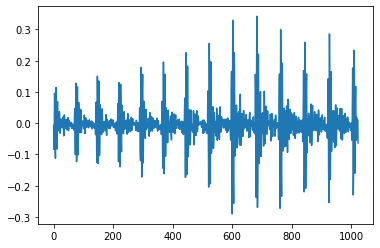

In [94]:
plt.plot(frame)
#plt.plot(out_preemph_c * 2**(-15-Shift))

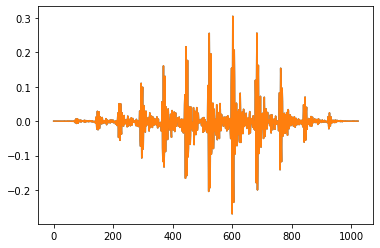

In [95]:
plt.plot(win_frame)
plt.plot(out_window_c * 2**(-15-Shift))

5.454088445308242e-05

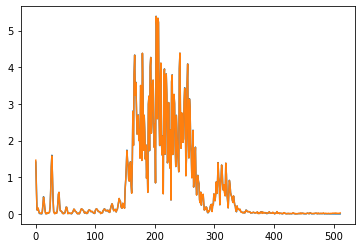

In [96]:
plt.plot(np.abs(np_fft[0:-1]))
plt.plot(np.abs(out_rfft * 2**(-8-Shift)))
mse_cplx(np_fft[0:-1], out_rfft * 2**(-8-Shift))

In [83]:
# FLOAT

In [58]:
out_window_c = np.array([
		-0.000000, -0.000000, -0.000000, -0.000000, -0.000001, -0.000001, -0.000001, -0.000002, -0.000002, -0.000003, -0.000005, -0.000005, -0.000005, -0.000003, -0.000006, -0.000010, -0.000011, -0.000014, -0.000012, -0.000010, -0.000011, -0.000012, -0.000014, -0.000024, -0.000024, -0.000019, -0.000020, -0.000021, -0.000024, -0.000027, -0.000030, -0.000038, -0.000037, -0.000044, -0.000052, -0.000044, -0.000050, -0.000047, -0.000039, -0.000053, -0.000060, -0.000070, -0.000082, -0.000052, -0.000063, -0.000086, -0.000067, -0.000065, -0.000077, -0.000106, -0.000127, -0.000122, -0.000105, -0.000099, -0.000121, -0.000133, -0.000145, -0.000130, -0.000134, -0.000160, -0.000136, -0.000132, -0.000141, -0.000127, -0.000140, -0.000205, -0.000210, -0.000166, -0.000169, -0.000154, -0.000168, -0.000177, -0.000157, -0.000185, -0.000197, -0.000185, -0.000184, -0.000184, -0.000184, -0.000255, -0.000226, -0.000198, -0.000239, -0.000250, -0.000266, -0.000238, -0.000251, -0.000200, -0.000248, -0.000372, -0.000314, -0.000290, -0.000322, -0.000300, -0.000373, -0.000305, -0.000276, -0.000394, -0.000276, -0.000262, -0.000388, -0.000475, -0.000464, -0.000422, -0.000496, -0.000371, -0.000340, -0.000486, -0.000537, -0.000524, -0.000426, -0.000484, -0.000524, -0.000477, -0.000413, -0.000547, -0.000676, -0.000442, -0.000257, -0.000355, -0.000776, -0.000728, -0.000527, -0.000656, -0.000447, -0.000608, -0.000922, -0.000520, -0.000287, -0.000595, -0.000669, -0.000552, -0.000555, -0.000775, -0.001074, -0.000911, -0.000748, -0.000259, -0.000227, -0.000743, -0.000583, -0.000451, -0.000561, -0.000287, -0.000453, -0.000821, -0.000344, -0.000668, -0.000894, -0.000322, -0.001098, -0.001490, 0.000309, 0.000344, -0.001317, -0.001288, -0.000324, 0.000564, -0.000982, -0.002734, -0.000911, 0.000467, -0.000744, -0.000998, -0.000242, -0.001150, -0.001054, -0.000948, -0.001894, -0.000143, 0.000729, -0.001188, -0.002736, -0.003015, -0.001274, 0.000536, 0.000299, -0.000719, -0.001097, -0.001091, -0.001371, -0.001062, -0.000815, -0.001179, 0.000061, -0.000062, -0.001757, -0.001333, -0.001800, -0.001698, -0.000269, -0.000234, -0.000519, -0.001038, -0.001423, -0.001144, -0.001311, -0.002912, -0.003476, -0.001055, 0.000871, -0.000358, -0.001351, -0.000229, 0.000105, -0.000677, -0.001611, -0.001764, -0.001248, -0.001006, -0.001202, -0.001712, -0.001390, -0.001208, -0.001629, -0.001033, -0.000370, -0.000641, -0.001104, -0.001481, -0.001265, -0.001563, -0.002097, -0.002149, -0.002251, -0.001326, -0.000225, -0.000402, -0.001305, -0.000842, -0.000231, -0.000466, -0.000900, -0.001760, -0.001825, -0.001545, -0.001730, -0.001959, -0.000884, 0.000288, -0.000758, -0.002207, -0.003004, -0.002378, -0.000184, -0.000228, -0.002553, -0.003350, -0.001759, -0.000351, -0.001192, -0.001881, -0.001133, -0.000480, -0.001087, -0.001884, -0.001193, -0.000815, -0.001068, -0.001728, -0.001190, -0.000661, -0.001726, -0.001100, -0.000513, -0.001258, -0.002156, -0.001762, -0.000804, -0.001468, -0.001444, -0.000918, -0.001427, -0.001636, -0.001731, -0.002218, -0.001749, -0.000603, -0.000711, -0.001412, -0.001734, -0.002131, -0.001947, -0.001870, -0.001700, -0.000953, -0.001193, -0.001907, -0.001644, -0.001267, -0.002029, -0.002465, -0.002142, -0.001572, -0.000884, -0.001889, -0.002508, -0.001184, -0.001764, -0.002678, -0.001858, -0.001439, -0.001348, -0.001746, -0.002543, -0.002377, -0.001214, -0.001919, -0.002930, -0.002258, -0.000790, -0.000997, -0.002615, -0.001990, -0.001422, -0.001406, -0.001766, -0.002754, -0.002430, -0.001305, -0.002050, -0.002672, -0.001895, -0.002352, -0.002126, -0.002070, -0.001861, -0.001456, -0.001920, -0.002386, -0.002351, -0.002251, -0.002436, -0.002068, -0.001874, -0.002061, -0.002924, -0.002888, -0.002536, -0.002181, -0.002715, -0.003090, -0.002870, -0.003366, -0.002267, -0.002577, -0.004075, -0.002757, -0.001196, -0.002306, -0.003564, -0.002676, -0.002544, -0.002313, -0.002105, -0.003310, -0.003658, -0.002826, -0.002181, -0.002625, -0.003462, -0.003179, -0.002183, -0.002312, -0.003208, -0.003217, -0.003252, -0.002339, -0.001123, -0.002253, -0.002611, -0.002921, -0.003687, -0.002405, -0.002463, -0.003081, -0.003037, -0.003124, -0.001900, -0.002831, -0.003949, -0.003156, -0.002568, -0.002808, -0.003886, -0.003371, -0.001625, -0.002181, -0.004346, -0.003458, -0.001640, -0.001140, -0.001143, -0.002346, -0.003153, -0.002624, -0.002442, -0.003012, -0.003208, -0.003080, -0.002788, -0.002876, -0.002746, -0.002344, -0.003114, -0.003066, -0.002934, -0.002995, -0.002726, -0.002180, -0.002875, -0.003407, -0.001888, -0.003003, -0.002703, -0.001954, -0.002881, -0.002689, -0.003538, -0.003796, -0.002818, -0.001214, -0.001866, -0.004020, -0.002724, -0.002756, -0.002675, -0.001482, -0.002484, -0.003374, -0.003551, -0.002180, -0.001207, -0.002561, -0.003602, -0.002800, -0.003296, -0.003532, -0.002232, -0.002496, -0.002994, -0.002823, -0.002419, -0.002481, -0.003769, -0.003629, -0.003105, -0.003932, -0.003671, -0.003058, -0.002091, -0.003272, -0.003777, -0.002807, -0.002484, -0.001983, -0.003645, -0.003411, -0.002316, -0.001694, -0.001696, -0.002919, -0.002832, -0.002567, -0.003525, -0.004008, -0.002424, -0.001977, -0.002998, -0.003570, -0.003694, -0.002313, -0.000872, -0.001987, -0.003765, -0.004068, -0.002714, -0.001901, -0.003593, -0.002387, -0.000967, -0.002026, -0.002845, -0.003633, -0.002878, -0.002000, -0.001880, -0.002214, -0.002762, -0.002368, -0.002643, -0.003617, -0.002920, -0.002372, -0.003529, -0.003258, -0.002222, -0.003167, -0.003777, -0.003169, -0.001920, -0.001677, -0.002195, -0.002410, -0.002318, -0.002257, -0.003081, -0.002686, -0.002289, -0.002563, -0.002075, -0.001831, -0.003510, -0.004669, -0.002869, -0.002411, -0.002441, -0.001952, -0.003050, -0.003721, -0.003233, -0.001280, -0.002256, -0.003565, -0.002590, -0.002041, -0.002223, -0.003714, -0.003532, -0.002860, -0.002251, -0.001460, -0.002249, -0.003251, -0.002368, -0.003369, -0.004034, -0.002335, -0.003000, -0.003484, -0.003451, -0.003329, -0.003327, -0.004021, -0.002719, -0.001661, -0.001660, -0.002684, -0.002712, -0.002470, -0.003100, -0.002526, -0.002644, -0.002192, -0.001800, -0.001919, -0.002396, -0.004159, -0.003439, -0.002271, -0.003164, -0.003518, -0.002710, -0.002053, -0.002051, -0.003266, -0.004153, -0.002904, -0.003315, -0.004406, -0.002689, -0.000885, -0.002977, -0.004005, -0.002587, -0.002526, -0.002993, -0.002959, -0.002663, -0.001899, -0.002452, -0.003002, -0.002852, -0.003285, -0.002119, -0.002985, -0.004053, -0.003151, -0.002079, -0.002334, -0.003856, -0.004194, -0.002955, -0.002263, -0.002917, -0.003198, -0.002765, -0.002021, -0.003608, -0.003887, -0.001982, -0.002403, -0.003162, -0.002451, -0.002503, -0.003229, -0.003418, -0.003356, -0.003349, -0.003399, -0.002530, -0.002748, -0.004183, -0.004313, -0.003008, -0.002258, -0.003380, -0.004524, -0.003860, -0.002567, -0.003625, -0.004976, -0.004232, -0.003790, -0.003972, -0.003828, -0.003147, -0.003784, -0.005168, -0.004996, -0.003679, -0.002977, -0.004270, -0.004630, -0.003748, -0.003450, -0.004020, -0.004352, -0.004182, -0.003077, -0.002262, -0.002853, -0.004010, -0.004929, -0.003629, -0.002542, -0.002484, -0.003369, -0.004380, -0.004164, -0.003266, -0.002854, -0.003449, -0.003540, -0.002754, -0.002372, -0.003409, -0.003848, -0.003787, -0.003504, -0.002952, -0.004022, -0.003375, -0.002463, -0.002989, -0.003950, -0.003865, -0.002262, -0.002926, -0.003540, -0.003457, -0.003233, -0.003008, -0.003257, -0.003341, -0.003659, -0.003084, -0.002980, -0.003180, -0.003400, -0.003274, -0.002296, -0.003342, -0.003171, -0.001704, -0.001698, -0.002820, -0.003734, -0.002531, -0.001985, -0.002512, -0.002923, -0.002074, -0.002109, -0.003284, -0.002706, -0.002738, -0.002791, -0.003234, -0.003650, -0.002865, -0.002662, -0.002715, -0.002747, -0.003409, -0.003080, -0.002524, -0.003158, -0.002647, -0.002370, -0.002729, -0.002921, -0.002502, -0.002147, -0.002399, -0.002850, -0.003498, -0.002965, -0.002416, -0.002366, -0.002845, -0.002773, -0.001594, -0.001723, -0.002158, -0.002704, -0.003188, -0.002375, -0.002040, -0.002669, -0.002190, -0.001677, -0.002336, -0.002214, -0.002111, -0.001900, -0.001979, -0.002531, -0.002356, -0.001342, -0.001620, -0.002496, -0.001778, -0.002120, -0.002162, -0.001925, -0.001914, -0.001887, -0.002098, -0.001900, -0.001636, -0.001158, -0.001603, -0.001826, -0.001781, -0.001706, -0.001664, -0.001751, -0.001886, -0.001732, -0.001451, -0.001774, -0.001764, -0.001597, -0.001774, -0.001253, -0.000831, -0.001361, -0.001322, -0.001298, -0.001185, -0.000954, -0.000844, -0.001693, -0.002003, -0.001279, -0.001559, -0.001994, -0.002337, -0.001571, -0.001154, -0.001467, -0.001777, -0.001764, -0.001191, -0.001074, -0.001580, -0.001569, -0.000879, -0.000846, -0.000933, -0.001421, -0.001761, -0.001478, -0.001008, -0.001001, -0.001710, -0.001673, -0.001401, -0.001218, -0.000867, -0.000764, -0.001118, -0.001384, -0.001256, -0.001128, -0.001038, -0.001389, -0.001183, -0.000980, -0.001163, -0.000997, -0.000756, -0.000893, -0.001214, -0.001020, -0.000957, -0.001195, -0.001291, -0.000934, -0.000624, -0.000609, -0.000501, -0.000881, -0.001256, -0.000916, -0.000750, -0.001174, -0.001318, -0.001009, -0.000828, -0.000905, -0.000972, -0.000889, -0.000753, -0.000755, -0.000568, -0.000580, -0.000884, -0.000726, -0.001231, -0.001227, -0.000730, -0.000875, -0.000625, -0.000701, -0.000882, -0.000678, -0.000600, -0.000783, -0.000799, -0.000798, -0.000736, -0.000638, -0.000743, -0.000594, -0.000602, -0.000720, -0.000776, -0.000533, -0.000457, -0.000827, -0.000557, -0.000306, -0.000584, -0.000870, -0.000591, -0.000525, -0.000852, -0.000646, -0.000607, -0.000711, -0.000507, -0.000567, -0.000667, -0.000541, -0.000627, -0.000694, -0.000577, -0.000548, -0.000557, -0.000605, -0.000623, -0.000679, -0.000680, -0.000387, -0.000555, -0.000743, -0.000594, -0.000771, -0.000693, -0.000513, -0.000566, -0.000452, -0.000463, -0.000492, -0.000512, -0.000696, -0.000561, -0.000354, -0.000531, -0.000609, -0.000455, -0.000543, -0.000569, -0.000533, -0.000498, -0.000368, -0.000394, -0.000330, -0.000424, -0.000482, -0.000399, -0.000473, -0.000382, -0.000330, -0.000375, -0.000350, -0.000285, -0.000334, -0.000369, -0.000319, -0.000279, -0.000335, -0.000399, -0.000239, -0.000168, -0.000291, -0.000371, -0.000418, -0.000380, -0.000296, -0.000269, -0.000182, -0.000147, -0.000281, -0.000308, -0.000291, -0.000293, -0.000228, -0.000225, -0.000218, -0.000227, -0.000208, -0.000190, -0.000199, -0.000186, -0.000180, -0.000172, -0.000211, -0.000155, -0.000119, -0.000173, -0.000156, -0.000209, -0.000212, -0.000143, -0.000129, -0.000084, -0.000093, -0.000115, -0.000098, -0.000124, -0.000144, -0.000140, -0.000091, -0.000086, -0.000110, -0.000099, -0.000061, -0.000082, -0.000101, -0.000053, -0.000057, -0.000059, -0.000067, -0.000085, -0.000069, -0.000047, -0.000041, -0.000063, -0.000082, -0.000061, -0.000037, -0.000031, -0.000038, -0.000046, -0.000036, -0.000034, -0.000040, -0.000024, -0.000039, -0.000047, -0.000032, -0.000028, -0.000027, -0.000033, -0.000025, -0.000018, -0.000017, -0.000020, -0.000019, -0.000013, -0.000014, -0.000011, -0.000008, -0.000009, -0.000008, -0.000007, -0.000005, -0.000005, -0.000005, -0.000004, -0.000002, -0.000002, -0.000002, -0.000001, -0.000001, -0.000001, -0.000000, -0.000000, -0.000000, -0.000000, -0.000000, ])

out_swapped_fft = np.array([
	-0.823974-0.823929j, 0.433087+0.366905j, -0.021698+0.069689j, -0.042805-0.059472j, 0.072012+0.039599j, -0.021665-0.005827j, -0.006007-0.013220j, 0.000861+0.023864j, 0.002590-0.015278j, 0.002205-0.002767j, -0.013630+0.006841j, 0.015290-0.018864j, -0.005853+0.023692j, -0.004248-0.006359j, 0.006728-0.004731j, -0.001277+0.009899j, 0.001546-0.006788j, 0.002733-0.003170j, -0.010230-0.007611j, 0.008511+0.011568j, -0.001219+0.001105j, -0.003324-0.007605j, 0.001700+0.013449j, -0.005145-0.011348j, 0.013886+0.000415j, -0.012681+0.002802j, -0.001686-0.001650j, 0.007285-0.000493j, -0.003180+0.009773j, 0.003304-0.009436j, -0.000128-0.002456j, -0.003789+0.008764j, 0.007486-0.007987j, -0.010313+0.002684j, 0.002675+0.000732j, -0.001048+0.001753j, 0.006943-0.000527j, 0.003137-0.001499j, -0.016179-0.006208j, 0.009151+0.003676j, -0.000526+0.010275j, 0.007166-0.006345j, -0.011249-0.006589j, 0.005649+0.000245j, -0.009026+0.012765j, 0.017033-0.006729j, -0.014072+0.000481j, 0.007051-0.004920j, 0.001135-0.004206j, -0.005931+0.012061j, -0.000728+0.001010j, 0.005029-0.012276j, -0.000405+0.011307j, 0.002926-0.001754j, -0.008229-0.007786j, 0.001532+0.002332j, 0.004717+0.006686j, 0.000090-0.001936j, -0.000584-0.003507j, -0.002734-0.000957j, 0.003290-0.000516j, -0.004506+0.004040j, 0.001682+0.001218j, -0.000890-0.000768j, 0.004131-0.010767j, -0.001598+0.017320j, -0.000360-0.009041j, -0.004697+0.005413j, 0.009913-0.011494j, -0.008853+0.008109j, 0.004962-0.005440j, -0.003699+0.009557j, 0.003151-0.001956j, -0.001528-0.003287j, -0.004215-0.005630j, 0.001316+0.009731j, 0.003705-0.002962j, 0.012022-0.000920j, -0.015386-0.007525j, -0.004087+0.001691j, 0.001598+0.006754j, 0.004090+0.006530j, 0.014448-0.002206j, -0.011334-0.008341j, -0.005833-0.002785j, -0.001279-0.001119j, 0.001275+0.018768j, 0.011097-0.012854j, -0.007840+0.000033j, 0.000267+0.004579j, -0.003928-0.009242j, 0.004337+0.006147j, 0.008137-0.000973j, -0.013942-0.004208j, 0.001206+0.006275j, 0.007291+0.001295j, 0.000536-0.004936j, -0.001312+0.001911j, 0.001005-0.002276j, -0.012147+0.003726j, 0.009174-0.000467j, -0.001446-0.004694j, 0.008986+0.008737j, -0.009406-0.003744j, -0.000017-0.007731j, 0.004639+0.006181j, -0.014180+0.003869j, 0.015788+0.001223j, 0.001719-0.007236j, 0.001189-0.000365j, -0.015499-0.006899j, 0.003267+0.017847j, 0.003122-0.004393j, 0.004933-0.004172j, 0.005872-0.001298j, -0.010057-0.006086j, -0.006642+0.014926j, 0.005351-0.001900j, 0.001562-0.000658j, 0.012165-0.008522j, -0.015420-0.006466j, -0.000326+0.005041j, -0.003239+0.016301j, 0.017829-0.008413j, -0.006485-0.008800j, -0.007229+0.004305j, 0.005861-0.000528j, -0.007832+0.005553j, 0.004077+0.001188j, 0.004706+0.000356j, 0.006712-0.008759j, -0.007639-0.002736j, -0.017093-0.000229j, 0.014858+0.023964j, -0.008562-0.014146j, 0.014092-0.006998j, 0.006343+0.006511j, -0.013914-0.013422j, -0.004159+0.009814j, 0.004434+0.006522j, -0.000691-0.002443j, 0.003254-0.000122j, 0.007397-0.005739j, -0.003475+0.005681j, -0.008412-0.005823j, -0.001570-0.003439j, 0.001161+0.009239j, 0.009689+0.002998j, -0.009677-0.013683j, 0.005158+0.019385j, -0.000866-0.016785j, -0.000756+0.006944j, 0.004601-0.007728j, -0.005612+0.003057j, -0.005697+0.004322j, 0.003168+0.001632j, 0.008850+0.006415j, 0.004775-0.015930j, -0.016388+0.007797j, 0.005737-0.006797j, -0.000069+0.008978j, 0.002562+0.005916j, -0.000589-0.012640j, 0.000015+0.005843j, 0.008112-0.005317j, -0.007394-0.003504j, -0.020700-0.000375j, 0.015760+0.018785j, 0.006433-0.004388j, 0.012366-0.009268j, -0.018782-0.006319j, 0.008917+0.007021j, -0.019290+0.002910j, 0.006378+0.002288j, 0.013067-0.005315j, -0.002308+0.002284j, 0.000705-0.001959j, -0.009503-0.004139j, 0.009629+0.011284j, -0.005088-0.010725j, -0.008485-0.000007j, 0.011134+0.011281j, 0.000015-0.011001j, 0.001485+0.005538j, -0.001437+0.001285j, -0.004455+0.007237j, 0.009311-0.021909j, -0.009005+0.007766j, -0.001892+0.003832j, 0.003566+0.010996j, -0.006698-0.012854j, 0.018267+0.009362j, -0.010477-0.018341j, -0.014302+0.014183j, 0.021906+0.002927j, -0.002769-0.011545j, -0.003687-0.001804j, -0.008878+0.007383j, 0.006329+0.009512j, -0.004033-0.005849j, 0.014413-0.007650j, -0.010971+0.005280j, 0.002119-0.013648j, -0.000179+0.016392j, -0.006151-0.003171j, 0.008726+0.011754j, -0.003420-0.009752j, 0.008763-0.018421j, -0.018967+0.015827j, 0.014327+0.003096j, -0.012089-0.003831j, 0.016588+0.011348j, -0.011252-0.014038j, 0.016026-0.004613j, -0.020162+0.005735j, 0.009724+0.005825j, -0.017613-0.013589j, 0.011671+0.026786j, 0.013129-0.019960j, -0.003273+0.001185j, -0.003390-0.000776j, -0.005416-0.006219j, -0.008681+0.005065j, 0.011276+0.017954j, -0.007176-0.000776j, 0.023805-0.012886j, -0.013919-0.010424j, -0.003879-0.000244j, -0.006676+0.008167j, 0.004428+0.011364j, -0.003575-0.002306j, -0.000883-0.013096j, 0.029810+0.012760j, -0.024787-0.012685j, 0.005590-0.011515j, -0.015591+0.033921j, 0.010442-0.017754j, 0.018900+0.009441j, -0.030541-0.019442j, 0.023813+0.010948j, -0.019747-0.003917j, 0.018051+0.014000j, -0.010881-0.021006j, -0.009817+0.012685j, 0.021906+0.011448j, -0.007119-0.008236j, 0.008256-0.014820j, -0.007260+0.006406j, -0.021118+0.000292j, 0.012976-0.000583j, 0.002041+0.015423j, 0.002442-0.009199j, 0.018198+0.003207j, -0.015342-0.018021j, -0.003534+0.008986j, -0.013501+0.009521j, 0.008798-0.004781j, 0.015431+0.014195j, -0.001752-0.022302j, -0.013731-0.007944j, -0.001875+0.030534j, 0.019438-0.022300j, -0.010571+0.006477j, -0.020948-0.009268j, 0.011126+0.023480j, 0.038874-0.011618j, -0.030804+0.008936j, -0.011477-0.041132j, 0.021882+0.040976j, -0.023733-0.029224j, -0.007548+0.029111j, 0.036965+0.016015j, 0.002901-0.033670j, -0.018371+0.003277j, 0.005991-0.027865j, -0.025907+0.044151j, -0.001055-0.010195j, 0.042501+0.023150j, -0.006883-0.022882j, -0.015483-0.024064j, -0.011610+0.015665j, -0.002568+0.013766j, 0.040611-0.005952j, -0.043334-0.006461j, 0.017228+0.004084j, 0.006171-0.003377j, 0.007209+0.016440j, -0.013823-0.032155j, -0.018557+0.021583j, 0.013177+0.006860j, 0.011866-0.002493j, 0.021373-0.001677j, -0.022275-0.019718j, -0.023478-0.007697j, 0.006880+0.034197j, 0.012835-0.000292j, -0.006321-0.013000j, 0.001199+0.027711j, 0.037455-0.042159j, -0.032502+0.004106j, -0.025010+0.001648j, 0.010856+0.011987j, 0.012262+0.016010j, 0.023652+0.004954j, -0.008831-0.055853j, -0.036145+0.035608j, 0.018544-0.013894j, 0.013192+0.028527j, -0.007171-0.017070j, -0.003264-0.011686j, -0.004859+0.007508j, -0.000234+0.003244j, 0.014414+0.012393j, -0.013259-0.003931j, 0.011912-0.027296j, 0.003742+0.026833j, -0.023245-0.020726j, 0.007616+0.027318j, 0.008359-0.003963j, -0.004998-0.015495j, 0.010760+0.009226j, -0.007751-0.016629j, -0.006246+0.012348j, -0.002371+0.021462j, 0.005263-0.031928j, 0.017002+0.010396j, -0.022822+0.000897j, 0.008587+0.005454j, 0.002403-0.017688j, -0.005070+0.018499j, -0.009567-0.016036j, 0.008888+0.022659j, 0.020571-0.008242j, -0.020829-0.024290j, 0.003346+0.018170j, -0.010662-0.004140j, 0.000258+0.025729j, 0.029036-0.019347j, -0.021930-0.007175j, 0.008039+0.009454j, -0.010312-0.009120j, -0.002168+0.003420j, 0.005768-0.001281j, 0.005384+0.010749j, 0.000233-0.001317j, 0.003975-0.008575j, -0.018077-0.014961j, 0.007344+0.019138j, -0.016290+0.013954j, 0.027612+0.003650j, 0.016372-0.021569j, -0.031396-0.013278j, -0.000318+0.003590j, -0.008376+0.017094j, 0.013488-0.002249j, -0.002025+0.001216j, 0.016568+0.005574j, -0.002628-0.016477j, -0.002636+0.005414j, -0.018639-0.010147j, -0.006940+0.015583j, 0.018820+0.016655j, 0.012852-0.016227j, -0.005891-0.016461j, -0.023001+0.002404j, 0.015922+0.011164j, -0.002321+0.002453j, -0.000476+0.012058j, 0.006214-0.021385j, 0.005624+0.008482j, -0.019564-0.021549j, 0.017632+0.025516j, -0.027527-0.009744j, 0.027082+0.016537j, 0.001865-0.015244j, -0.012188+0.007225j, 0.006410-0.027368j, -0.011580+0.024589j, -0.011698-0.005363j, 0.034462+0.027991j, -0.003803-0.027468j, 0.005592-0.007085j, -0.029555-0.002825j, -0.002595+0.019302j, 0.009569+0.007350j, 0.009504-0.022186j, 0.004629+0.013583j, 0.007212-0.019567j, -0.017256+0.005184j, -0.015860+0.004235j, 0.022726+0.018871j, -0.001865-0.012253j, 0.007093-0.006684j, -0.022958-0.002372j, 0.005170+0.011538j, 0.005243+0.004301j, 0.006373-0.016192j, 0.001255+0.004977j, -0.006874-0.003341j, -0.005631+0.003834j, 0.001041+0.008425j, 0.021639-0.002104j, -0.019041-0.008601j, 0.008636-0.005537j, -0.012737+0.011284j, 0.005427+0.008981j, 0.002757-0.017520j, 0.003597+0.007595j, -0.003066+0.001222j, -0.013241-0.002015j, 0.026777-0.001335j, -0.018103-0.000920j, 0.009202+0.006041j, -0.013078-0.006673j, 0.006914+0.001156j, -0.003132-0.000233j, 0.005716+0.001048j, -0.005820+0.008355j, 0.009638-0.004883j, -0.006910-0.009355j, 0.000947+0.001294j, -0.000292+0.007705j, 0.000551+0.003786j, 0.002736-0.008015j, -0.003915-0.012873j, -0.010431+0.014693j, 0.006331+0.015100j, 0.018595+0.001475j, -0.002945-0.027400j, -0.017806-0.007585j, -0.013004+0.014366j, 0.021404+0.018368j, 0.010288-0.008391j, -0.005218-0.007514j, -0.000170-0.012014j, -0.018899+0.012855j, 0.008603+0.006806j, 0.015634-0.003044j, -0.013476-0.002702j, -0.002571-0.005796j, 0.001421+0.005733j, 0.004192+0.007392j, -0.000052-0.007777j, 0.006428-0.004015j, -0.012447+0.004763j, 0.005407+0.000576j, -0.012697+0.000965j, 0.020242-0.002917j, -0.003088-0.003456j, -0.005339+0.010841j, -0.006606-0.011153j, 0.010846+0.001697j, 0.003249+0.004363j, -0.014390-0.000792j, 0.007101+0.001195j, -0.002170-0.007069j, 0.002520+0.003913j, 0.008682+0.006942j, -0.013151-0.011685j, 0.000598+0.007273j, 0.006384-0.002216j, -0.005575+0.000286j, -0.002547+0.005615j, 0.014441-0.005001j, -0.003683-0.004803j, -0.008049+0.009074j, 0.000061-0.017886j, -0.008442+0.029053j, 0.018669-0.019338j, -0.002128+0.010490j, -0.004647-0.014583j, -0.010530+0.008923j, 0.009832-0.002159j, 0.009374+0.011140j, -0.009383-0.016900j, -0.001572+0.000755j, -0.002670+0.010947j, 0.005975-0.004177j, -0.001303+0.006774j, 0.001893-0.014666j, -0.007763+0.008878j, 0.008967-0.003026j, -0.001213-0.001211j, -0.011960+0.004550j, 0.011274-0.004446j, 0.000376+0.008117j, -0.003320-0.000467j, 0.004874-0.016511j, -0.001645+0.016984j, -0.011443-0.006244j, 0.014572+0.002318j, -0.007977-0.003417j, 0.000742-0.001004j, 0.013552+0.007458j, -0.008986-0.009576j, -0.003061+0.002037j, -0.007623+0.002061j, 0.010478-0.000814j, -0.004726+0.007051j, -0.006921-0.004892j, 0.025579-0.006107j, -0.020589+0.016349j, 0.007657-0.014827j, -0.003654+0.002519j, -0.015168+0.003073j, 0.024489+0.000502j, -0.013781-0.006181j, -0.005716-0.022305j, 0.040614+0.073834j, -0.060806-0.043638j, 0.070597-0.021946j, 0.369151+0.435695j, ])

out_rfft = np.array([
	-1.647903-0.000045j, 0.802215-0.068825j, 0.048885+0.091668j, -0.103517-0.015967j, 0.112627-0.034204j, -0.027505+0.016641j, -0.019731-0.007047j, 0.025355+0.022961j, -0.012820-0.017744j, -0.001010-0.005562j, -0.006319+0.021702j, -0.005115-0.035421j, 0.019788+0.029926j, -0.011298-0.001617j, 0.001665-0.011696j, 0.009664+0.010791j, -0.005840-0.008755j, -0.001029-0.005426j, -0.018080+0.002548j, 0.020773+0.003452j, -0.000068+0.002021j, -0.011415-0.003693j, 0.016814+0.010882j, -0.017446-0.004432j, 0.013586-0.017243j, -0.009337+0.019378j, -0.003678-0.001230j, 0.007020-0.008341j, 0.007907+0.013775j, -0.008083-0.014072j, -0.002572-0.000820j, 0.006612+0.011616j, -0.001189-0.015998j, -0.008851+0.015858j, 0.003946-0.005744j, 0.002028+0.006654j, 0.006167-0.011569j, -0.000110-0.003337j, -0.023237+0.011322j, 0.016486-0.005380j, 0.009847+0.010255j, -0.002636-0.016524j, -0.017343+0.009887j, 0.005928-0.010276j, 0.005347+0.030274j, 0.011563-0.033189j, -0.013395+0.018394j, -0.000655-0.014826j, -0.006284-0.000699j, 0.010643+0.017215j, 0.001246-0.004170j, -0.007609-0.009480j, 0.008370+0.008559j, 0.004005-0.006498j, -0.020697+0.002789j, 0.010666-0.000467j, 0.008238-0.001433j, -0.005658+0.003048j, 0.003514+0.001653j, -0.011444-0.005223j, 0.005057-0.003150j, 0.008647+0.007268j, -0.008613+0.004182j, 0.000711-0.009764j, -0.007430-0.004269j, 0.020199+0.017385j, -0.012670-0.009082j, 0.005119+0.005853j, -0.008875-0.016986j, 0.003793+0.012187j, -0.004597+0.001641j, 0.009595+0.001083j, 0.003623-0.005434j, -0.006369+0.002751j, -0.014620-0.003798j, 0.014651+0.011316j, 0.008971-0.003560j, -0.005161-0.023370j, -0.012946+0.013497j, -0.007492+0.005459j, 0.007270+0.011790j, 0.027818-0.004245j, -0.000570-0.023243j, -0.023100+0.000679j, -0.016809+0.021003j, 0.013763+0.007230j, 0.019707-0.004509j, -0.004353-0.023508j, -0.010375+0.011436j, 0.000675+0.008245j, -0.002836-0.003177j, 0.006671-0.006412j, 0.002754-0.004256j, -0.014234+0.009195j, 0.008305+0.008734j, 0.001155-0.011659j, 0.002949+0.000242j, -0.002038-0.000152j, 0.005169+0.001036j, -0.014088+0.005659j, 0.011475-0.004848j, -0.016897-0.007037j, 0.026091+0.010077j, -0.014780-0.000711j, -0.005064-0.003762j, 0.009312-0.005260j, -0.006015+0.021567j, 0.011487-0.011096j, -0.008360-0.016203j, 0.004906+0.007337j, -0.024427+0.004310j, 0.024352+0.012156j, 0.002979-0.008492j, -0.003855-0.007957j, -0.006380-0.002361j, -0.001155-0.000867j, 0.003637+0.020900j, 0.006166-0.003931j, 0.008636-0.008350j, -0.021169-0.012526j, -0.001476+0.012864j, -0.004273+0.010518j, 0.031464-0.003742j, -0.012077-0.017163j, -0.016894-0.009646j, -0.000492+0.022430j, 0.009486-0.012055j, 0.001011+0.025881j, 0.011783-0.004158j, 0.005365-0.019031j, -0.028445-0.011485j, 0.000332+0.010301j, -0.015185+0.028231j, 0.049597-0.014222j, -0.017917+0.001688j, -0.002256-0.030952j, -0.000602+0.024689j, -0.014475-0.007439j, -0.000689+0.016558j, 0.031871-0.006242j, -0.028249-0.000500j, 0.024149-0.017822j, -0.025182+0.009666j, 0.009099-0.003939j, -0.004077+0.022936j, 0.002116-0.010753j, 0.001713-0.002259j, 0.019641-0.007706j, -0.025061-0.007696j, -0.003850+0.013393j, 0.001457+0.017010j, 0.023945-0.008411j, -0.003465-0.018247j, -0.019476+0.005615j, -0.000074-0.003595j, -0.006400+0.013413j, 0.019316-0.002259j, -0.005616-0.004473j, 0.012438+0.011186j, -0.004276-0.020165j, 0.003194-0.002600j, -0.030618+0.003324j, 0.005673+0.023426j, 0.027989+0.004556j, -0.012087-0.019811j, 0.010367-0.014047j, -0.022294+0.014509j, 0.007484+0.006257j, -0.000792-0.000683j, 0.006246-0.012422j, 0.002185+0.006945j, 0.001170-0.005487j, -0.012426+0.010929j, 0.010796-0.008304j, -0.022773-0.002036j, 0.023072+0.025787j, 0.005887-0.024431j, -0.012525+0.003393j, 0.010481-0.017962j, -0.027935+0.018790j, 0.017166+0.014334j, 0.016542-0.021392j, -0.015011+0.012565j, 0.000458-0.018733j, -0.001288+0.017721j, 0.010655-0.002109j, -0.025738-0.008542j, 0.019585-0.004251j, -0.000737+0.032173j, 0.004362-0.021296j, -0.006364-0.012280j, -0.008141+0.011292j, 0.008208-0.005510j, -0.005588+0.017200j, 0.008651+0.001410j, 0.010139-0.024874j, -0.026644+0.016452j, 0.009392-0.023489j, 0.008639+0.027711j, -0.014655+0.002055j, 0.015213-0.012254j, 0.000875-0.001226j, -0.005668-0.008810j, -0.002431+0.011317j, -0.010320+0.016399j, 0.019284-0.026862j, 0.014461+0.016658j, -0.032593-0.041873j, -0.014858+0.056462j, 0.024604-0.003462j, 0.013476-0.012378j, 0.014145-0.012327j, -0.026413-0.003707j, -0.031728-0.010443j, 0.031862+0.048900j, 0.005507-0.028244j, -0.009720+0.013973j, 0.015958+0.000808j, 0.008609-0.034727j, -0.023952+0.005340j, -0.024291+0.017400j, 0.020224+0.004441j, 0.011909+0.004649j, 0.015653-0.006416j, -0.016419-0.022493j, -0.017742+0.028192j, 0.007581-0.014455j, 0.005771+0.004238j, 0.018099-0.001951j, -0.042603+0.002556j, 0.039675+0.009410j, -0.002507-0.013891j, -0.009300-0.018550j, -0.018114+0.024536j, -0.009141+0.021886j, 0.045927-0.019181j, -0.002723+0.009386j, -0.022638-0.046575j, 0.003272+0.029734j, -0.017516-0.005435j, 0.001005+0.034689j, 0.038304-0.015082j, -0.007207-0.028953j, -0.024370+0.028643j, 0.023811-0.040906j, -0.013137+0.040929j, -0.030948-0.010139j, 0.038695+0.012887j, 0.011690-0.022674j, -0.021144+0.008535j, -0.010164-0.006701j, 0.018951+0.022553j, -0.001458-0.030775j, -0.013971+0.007956j, -0.001834+0.022313j, 0.015503-0.014106j, 0.008798+0.004781j, -0.013574-0.009432j, -0.003452-0.008976j, -0.015103+0.018033j, 0.017781-0.003448j, 0.002929+0.009452j, 0.001634-0.015648j, 0.013172-0.000150j, -0.021682+0.000514j, -0.007081-0.005137j, 0.008400+0.013617j, -0.005459+0.008032j, 0.019977-0.011378j, -0.009181-0.013266j, -0.011222+0.021164j, 0.016712-0.013067j, -0.017851+0.004936j, 0.022957-0.013106j, -0.027823+0.021312j, 0.015631-0.011865j, 0.012109+0.016945j, -0.019017-0.029952j, 0.007848+0.010519j, -0.022156+0.013157j, 0.027501-0.015645j, -0.000945+0.012972j, -0.002639+0.005764j, 0.003697-0.015269j, -0.007548-0.006034j, -0.003479+0.001105j, -0.014291+0.012408j, 0.027724+0.008923j, -0.009315-0.000134j, 0.008800-0.017509j, -0.008724-0.002910j, -0.004267+0.008983j, -0.001374-0.001542j, -0.002799-0.003542j, 0.011399+0.019431j, 0.008547-0.026270j, -0.014213+0.014563j, 0.005416-0.006358j, -0.014569+0.001006j, 0.015253-0.001723j, -0.009849+0.011979j, 0.013299-0.011688j, -0.013303+0.007463j, 0.013374-0.001603j, -0.012939-0.015218j, 0.005211+0.012157j, 0.000663+0.012517j, 0.002634-0.010089j, -0.003003+0.002500j, -0.001012-0.016761j, 0.002928+0.012346j, -0.012079-0.003262j, 0.013614+0.007789j, -0.002637+0.003973j, 0.009602-0.009096j, -0.014528-0.004039j, -0.000288-0.002470j, -0.005293+0.013989j, 0.021614-0.005480j, -0.013711-0.012478j, -0.007925+0.022058j, 0.018657-0.014700j, -0.006580+0.012922j, -0.003167-0.010830j, 0.004108-0.003588j, -0.011588-0.001622j, 0.012227+0.014264j, -0.006524-0.003892j, 0.002254-0.001251j, -0.004044-0.005772j, 0.005459+0.007530j, 0.003481-0.010014j, -0.005079+0.006099j, 0.002017+0.005225j, 0.002494-0.011076j, -0.007641+0.003392j, -0.004923+0.003257j, 0.003655+0.004156j, 0.013910-0.003897j, 0.003621-0.001138j, -0.017176-0.001100j, 0.005579-0.009089j, -0.015198+0.011983j, 0.011503+0.007595j, 0.007459+0.002389j, 0.012252-0.021103j, -0.016482-0.000077j, -0.010416+0.008595j, 0.003909-0.000541j, -0.000363+0.002362j, 0.010111+0.014498j, 0.001784-0.015870j, -0.003581-0.007988j, 0.001637+0.003726j, -0.015337+0.001141j, 0.008366+0.012673j, 0.006103-0.003100j, 0.006941-0.004695j, -0.008259-0.002503j, -0.004776-0.007589j, 0.001126+0.005063j, -0.005881+0.001300j, 0.010529+0.017569j, 0.003117-0.022453j, -0.007617+0.008391j, 0.005970+0.000460j, -0.002874-0.009045j, -0.004161+0.004745j, 0.001878+0.007374j, -0.006951-0.001138j, 0.013015-0.006144j, -0.003263+0.007816j, 0.000032-0.007800j, -0.000355+0.003773j, -0.001605-0.008499j, -0.011627+0.013208j, 0.013355-0.009190j, 0.004767+0.000635j, -0.002343+0.010471j, -0.000277-0.010195j, -0.005711+0.000992j, -0.002379+0.005952j, 0.005602-0.005551j, -0.003255-0.000085j, 0.001863+0.002004j, 0.000661-0.001858j, 0.001003+0.002056j, 0.000475-0.001442j, -0.006848+0.004339j, 0.014046-0.004516j, -0.011977-0.001173j, 0.002082-0.006776j, -0.006851+0.012647j, 0.010375-0.006376j, -0.001905+0.003846j, 0.004428+0.002270j, -0.003906-0.010218j, -0.007647+0.010196j, 0.005377-0.004404j, 0.003156+0.000049j, 0.001183+0.004326j, 0.000553-0.007795j, -0.010113+0.002609j, 0.004919+0.002165j, -0.002658+0.002316j, 0.009729-0.003338j, -0.005407+0.000178j, -0.001076-0.003846j, 0.001981+0.005191j, -0.007867+0.001019j, 0.009671+0.000006j, -0.002652-0.003262j, 0.006901+0.001660j, -0.011137-0.004740j, 0.002750+0.004469j, -0.002407-0.002296j, 0.003303+0.006226j, 0.000316-0.004599j, 0.002539-0.002425j, -0.006618+0.004049j, 0.006329-0.001989j, -0.002626-0.004854j, -0.000541+0.009852j, 0.002328-0.004350j, -0.001380-0.001469j, 0.005019+0.004039j, -0.012100-0.008177j, 0.003553+0.009824j, 0.008031-0.003612j, -0.006040+0.001435j, 0.002014-0.006671j, -0.002324+0.007593j, 0.004617-0.003355j, -0.001813-0.003746j, -0.002609+0.009008j, -0.001716-0.009595j, 0.003336+0.006208j, 0.002300-0.001458j, -0.003070-0.000870j, 0.002270+0.000242j, 0.000949+0.002255j, -0.009101-0.001082j, 0.009507-0.000696j, -0.006218+0.000064j, 0.006341-0.000729j, -0.004409+0.001016j, -0.000387+0.000924j, -0.001555-0.002852j, 0.008473+0.003042j, -0.006940+0.001845j, 0.003689-0.008189j, -0.002306+0.004925j, 0.001482+0.001728j, -0.005680-0.005057j, 0.003003+0.006355j, 0.003577-0.002085j, -0.001001-0.004206j, -0.000452+0.004143j, -0.000683-0.001110j, -0.000481+0.002529j, -0.002391-0.004964j, 0.007063+0.003082j, -0.004521+0.000435j, -0.002133+0.000153j, 0.003736-0.001296j, -0.000343-0.000832j, -0.000616+0.000027j, -0.002972+0.002593j, 0.004296-0.001829j, -0.002407-0.000031j, 0.001447+0.001893j, -0.000729-0.001256j, -0.000542-0.002179j, 0.002039+0.002084j, -0.002325+0.000630j, 0.001674-0.001084j, -0.001894-0.000095j, 0.002899+0.000724j, -0.002574+0.000297j, 0.000431-0.001492j, 0.000912+0.000868j, -0.001434-0.000174j, 0.001231+0.000425j, -0.000573-0.000086j, 0.000187-0.000444j, 0.000640+0.000269j, -0.001328-0.000047j, 0.001530+0.000065j, -0.001346-0.000673j, 0.000857+0.000671j, -0.000542-0.000249j, 0.000114+0.000495j, -0.000408-0.000088j, 0.001290-0.000658j, -0.001135+0.000582j, 0.000701-0.000219j, -0.000237+0.000094j, -0.000463+0.000079j, 0.000337+0.000085j, 0.000129-0.000151j, -0.000062+0.000127j, -0.000185-0.000207j, 0.000346+0.000035j, -0.000439-0.000275j, 0.000242+0.000607j, -0.000004-0.000401j, -0.000057-0.000008j, 0.000125+0.000163j, -0.000002+0.000031j, -0.000093-0.000133j, 0.000013+0.000033j, 0.000023-0.000035j, ])

print(out_swapped_fft.shape)

(512,)


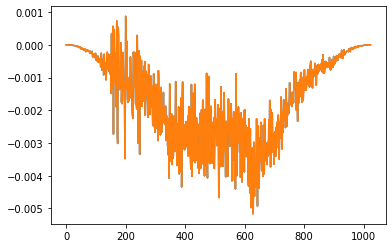

In [44]:
plt.plot(win_frame)
plt.plot(out_window_c)

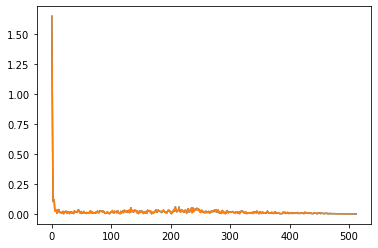

In [39]:
plt.plot(np.abs(np_fft))
plt.plot(np.abs(out_rfft))